## Assigment: Neural network basics

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

For this task I intentionally provide no boilerplate code, because very puprpose of this task is getting you comforatable with basic code template for desiging NNs in pytorch. I higly recommend you to revisit all the last seminar materials.

#### Task

* Implement simple **fully-convolutional** neural architecture for classification. Make sure it is small enought to run on your home machine.
* Provide dataset visulization.
* Provide train/test split and validation

#### Requirements

* Architecture should derive from `torch.nn.Module`
* Use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. But if you manage co simplify this step using dataset `torchivision`, I will only encourage you.
* Implement at least one data transformer, but make sure it is useful for classification task.
* Use FashionMNIST dataset https://github.com/zalandoresearch/fashion-mnist
* Make sure you can fix random seed for all components of your code to make experiments reproducible
* Since you architecure should be fully-convolutional, make sure it does not depend on input size.

#### UPD: The _fully-convolutional_ constraint has been dropped

### Solution

* imports
* dataset retrieval and transformation
* training process visualization function
* training function

In [1]:
%matplotlib inline
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from timeit import default_timer as timer

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(28, padding=4),  # useful because it prevents overfitting well
    torchvision.transforms.ToTensor(),
])
train_set = torchvision.datasets.FashionMNIST(root='fashion_mnist',
                                              train=True,
                                              download=True,
                                              transform=transform)
val_set = torchvision.datasets.FashionMNIST(root='fashion_mnist',
                                            train=False,
                                            transform=transform)

In [3]:
def visualize(losses, train_losses, val_losses, train_acc, val_acc, epoch, last_epoch_time, epoch_end=False):
    plt.clf()
    if epoch_end:
        n_subplots = 2
        plt.suptitle('Epoch {} finished in {:.3f} seconds'.format(epoch, last_epoch_time))
    else:
        n_subplots = 3
        if last_epoch_time:
            plt.suptitle('Current epoch: {}, last epoch finished in {:.3f} seconds'.format(epoch, last_epoch_time))
        else:
            plt.suptitle('Current epoch: {}'.format(epoch))
        plt.subplot(1, 3, 3)
        plt.plot(losses)
        plt.grid()
        plt.xlabel('Batch')
        ymin, ymax = plt.ylim()
        plt.ylim(0, ymax)
    plt.subplot(1, n_subplots, 1)
    plt.plot(train_acc, 'b.-', label='train')
    plt.plot(val_acc, 'r.-', label='val')
    plt.grid()
    plt.legend()
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(0, 1)
    plt.subplot(1, n_subplots, 2)
    plt.plot(train_losses, 'b.-', label='train')
    plt.plot(val_losses, 'r.-', label='val')
    plt.grid()
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [4]:
def train(model, batch_size, n_epochs, learning_rate, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    
    
    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=batch_size,
                                               shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size)
    
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    start_time = timer()
    train_losses = np.zeros(n_epochs)
    val_losses = np.zeros(n_epochs)
    train_acc = np.zeros(n_epochs)
    val_acc = np.zeros(n_epochs)
    last_epoch_time = 0
    for epoch in range(n_epochs):
        epoch_start_time = timer()
        
        train_corr = 0
        losses = np.zeros(len(train_loader))
        for t, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            losses[t] = loss.item()
            train_corr += (y_pred.argmax(dim=1) == y).sum().item()
            
            if (t + 1) % 100 == 0:
                visualize(losses, train_losses, val_losses, train_acc, val_acc, epoch, last_epoch_time)
        
        total_val_loss = 0
        val_corr = 0
        with torch.no_grad():
            for X, y in val_loader:
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                total_val_loss += loss.item()
                val_corr += (y_pred.argmax(dim=1) == y).sum().item()
            
        
        last_epoch_time = timer() - epoch_start_time
        train_losses[epoch] = losses.mean()
        val_losses[epoch] = total_val_loss / len(val_loader)
        train_acc[epoch] = train_corr / len(train_set)
        val_acc[epoch] = val_corr / len(val_set)
        visualize(losses, train_losses, val_losses, train_acc, val_acc, epoch, last_epoch_time, epoch_end=True)
    
    print('Learning finished in {:.3f} seconds'.format(timer() - start_time))
    plt.clf()

The model:

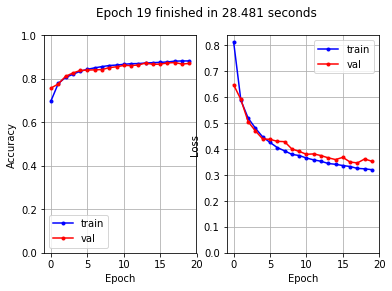

Learning finished in 583.945 seconds


<Figure size 432x288 with 0 Axes>

In [5]:
# 20 conv layers, max pooling, 140 nodes in last layer
class MyCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = torch.nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=2)
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = torch.nn.Linear(20 * 14 * 14, 140)
        self.linear2 = torch.nn.Linear(140, 20)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.max_pool(x)
        x = self.linear1(x.view(-1, 20 * 14 * 14)).clamp(min=0)
        x = self.linear2(x)
        return x

    
model = MyCNN()
train(model, batch_size=100, n_epochs=20, learning_rate=0.001, seed=117)